## IMPORTS

In [17]:
!apt-get install texlive-latex-extra texlive-fonts-recommended dvipng cm-super
import scipy.sparse.linalg as spla
import scipy.sparse as sp
import numpy as np
import matplotlib.pyplot as plt
import time
from collections import namedtuple, Counter
from scipy.optimize import curve_fit

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  cm-super-minimal dvisvgm fonts-droid-fallback fonts-lato fonts-lmodern fonts-noto-mono
  fonts-texgyre fonts-urw-base35 ghostscript libapache-pom-java libcommons-logging-java
  libcommons-parent-java libfontbox-java libfontenc1 libgs9 libgs9-common libidn12 libijs-0.35
  libjbig2dec0 libkpathsea6 libpdfbox-java libptexenc1 libruby3.0 libsynctex2 libteckit0
  libtexlua53 libtexluajit2 libwoff1 libzzip-0-13 lmodern pfb2t1c2pfb poppler-data
  preview-latex-style rake ruby ruby-net-telnet ruby-rubygems ruby-webrick ruby-xmlrpc ruby3.0
  rubygems-integration t1utils tex-common tex-gyre texlive-base texlive-binaries texlive-latex-base
  texlive-latex-recommended texlive-pictures texlive-plain-generic tipa xfonts-encodings
  xfonts-utils
Suggested packages:
  fonts-noto fonts-freefont-otf | fonts-freefont-ttf ghostscript-x libavalon-framework-

# CODES

## EXACT DIAGONALIZATION

In [2]:
# Define operators
def clock_operators(q):
    """
    Define clock model operators for q-state system.

    Parameters:
    q: number of discrete states

    Returns:
    Clock and shift operator.
    """
    omega =  np.exp((2j * np.pi) / q)
    C = sp.csr_matrix(np.diag([omega ** m for m in range(q)]))
    S = sp.csr_matrix(np.roll(np.eye(q), shift=-1, axis=1))

    return C, S

def apply_operator_at_site(O, i, L, q):
    """
    Places an operator O at site i in an L-site q-state system.

    Parameters:
    O: operator to apply
    i: state index
    L: total number of sites
    q: number of discrete states per site

    Returns:
    The Kronecker product representing the operator acting on the full system.
    """
    L = int(L)
    if not (0 <= i < L):
        raise IndexError(f"Invalid site index i={i}. Must be between 0 and {L-1}")

    I_q = sp.identity(q, format="csr")
    op_list = [I_q] * L  # List of identity operators
    op_list[i] = O  # Apply operator at correct site

    # Compute the full Kronecker product
    full_operator = op_list[0]
    for op in op_list[1:]:
        full_operator = sp.kron(full_operator, op, format="csr")

    return full_operator

# Define Hamiltonian
def clock_hamiltonian(q, J, h, L, periodic = False):
    """
    Parameters:
    q: number of discrete states
    C: clock operator
    S: shift operator
    J: coupling constant
    h: external field strength
    L: number of sites
    """
    L = int(L)

    C, S = clock_operators(q)
    H = sp.csr_matrix((q**L, q**L))

    for i in range(1, L):
        H += (-J) * ((apply_operator_at_site(S, i-1, L, q) @ apply_operator_at_site(S.conj().T, i, L, q))
             + (apply_operator_at_site(S.conj().T, i-1, L, q) @ apply_operator_at_site(S, i, L, q)))
        H += (-J * (h / (2 * J))) * (apply_operator_at_site(C, i-1, L, q) + apply_operator_at_site(C.conj().T, i-1, L, q)
                                     + apply_operator_at_site(C, i, L, q) + apply_operator_at_site(C.conj().T, i, L, q))

    if periodic:
        H += (-J) * ((apply_operator_at_site(S, L-1, L, q) @ apply_operator_at_site(S.H, 0, L, q))
                                 + (apply_operator_at_site(S.conj().T, L-1, L, q) @ apply_operator_at_site(S, 0, L, q)))
    H += (-J * (h / (2 * J))) * (apply_operator_at_site(C, 0, L, q) + apply_operator_at_site(C.conj().T, 0, L, q)
                                 + apply_operator_at_site(C, L-1, L, q) + apply_operator_at_site(C.conj().T, L-1, L, q))
    return H

# Ground-state energy density
def E0_per_site(q, J, h, L):
    H = clock_hamiltonian(q, J, h, L)
    eigval = spla.eigsh(H, k=1, which='SA', return_eigenvectors=False)  # Use eigsh for real Hermitian
    E0 = np.real(eigval[0])
    return E0 / L

# Energy gap per site
def E0_and_E1_per_site(q, J, h, L):
    H = clock_hamiltonian(q, J, h, L)
    eigval = spla.eigsh(H, k=2, which='SA', return_eigenvectors=False)  # Use eigsh for real Hermitian
    E0 = np.real(eigval[0])
    E1 = np.real(eigval[1])
    return np.abs(E1 - E0) / L

## INFINITE-SYSTEM DMRG

In [3]:
Block = namedtuple("Block", ["length", "basis_size", "operator_dict"])
EnlargedBlock = namedtuple("EnlargedBlock", ["length", "basis_size", "operator_dict"])

def is_valid_block(block):
    for op in block.operator_dict.values():
        if op.shape[0] != block.basis_size or op.shape[1] != block.basis_size:
            return False
    return True

is_valid_enlarged_block = is_valid_block

# Define operators
def clock_operators(q):
    """
    Define clock model operators for q-state system.
    """
    if not isinstance(q, (int, np.integer)):
        raise TypeError(f"Expected integer for q, got {type(q)}")

    omega = np.exp(2j * np.pi / q)
    C = np.diag([omega ** n for n in range(q)])
    S = sp.lil_matrix((q, q), dtype=complex)
    for i in range(q - 1):
        S[i, i + 1] = 1
    S[q - 1, 0] = 1
    return sp.csr_matrix(C), sp.csr_matrix(S)

# Single-site Hamiltonian
def H1(q, h, J):
    C, S = clock_operators(q)

    return - h * (C + C.getH())

def initialize_block(q, J, h):
    return Block(length=1, basis_size=q, operator_dict={
        "H": H1(q, h, J),
        "conn_C": clock_operators(q)[0],
        "conn_S": clock_operators(q)[1],
    })

def enlarge_block(block, q, J, h):
    """Enlarges the given Block by adding a single site."""
    mblock = block.basis_size
    o = block.operator_dict

    # Single-site Hamiltonian term
    H_single = sp.kron(sp.identity(mblock), H1(q, h, J))

    # Neighbor interaction term (only between last site and new site)
    H_interaction = -J * (sp.kron(o["conn_S"], clock_operators(q)[1].conj().T) + sp.kron(o["conn_S"].conj().T, clock_operators(q)[1]))

    # New enlarged Hamiltonian
    enlarged_operator_dict = {
        "H": sp.kron(o["H"], sp.identity(q)) + H_single + H_interaction,
        "conn_C": (sp.kron(sp.identity(mblock), clock_operators(q)[0])),
        "conn_S": (sp.kron(sp.identity(mblock), clock_operators(q)[1])),
    }

    return EnlargedBlock(length=(block.length + 1), basis_size=(block.basis_size * q), operator_dict=enlarged_operator_dict)

def rotate_and_truncate(operator, transformation_matrix):
    """Transforms the operator to the new (possibly truncated) basis given by
    `transformation_matrix`.
    """
    return transformation_matrix.conj().transpose().dot(operator.dot(transformation_matrix))

def single_dmrg_step(sys, env, q, J, h, m):
    """Performs a single DMRG step for the q-state clock model."""
    sys_enl = enlarge_block(sys, q, J, h)
    env_enl = sys_enl if sys is env else enlarge_block(env, q, J, h)

    # Construct the superblock Hamiltonian
    superblock_hamiltonian = (
    sp.kron(sys_enl.operator_dict["H"], sp.identity(env_enl.basis_size)) +
    sp.kron(sp.identity(sys_enl.basis_size), env_enl.operator_dict["H"]) -J *
    (sp.kron(sys_enl.operator_dict["conn_S"], env_enl.operator_dict["conn_S"].getH()) + sp.kron(sys_enl.operator_dict["conn_S"].getH(), env_enl.operator_dict["conn_S"])
    ))
    (energy,), psi0 = spla.eigsh(superblock_hamiltonian, k=1, which="SA")

    psi0 = psi0.reshape([sys_enl.basis_size, -1], order="C")
    rho = np.dot(psi0, psi0.conjugate().transpose())

    evals, evecs = np.linalg.eigh(rho)
    possible_eigenstates = []
    for eval, evec in zip(evals, evecs.transpose()):
        possible_eigenstates.append((eval, evec))
    possible_eigenstates.sort(reverse=True, key=lambda x: x[0])  # largest eigenvalue first

    # Build the transformation matrix from the `m` overall most significant
    # eigenvectors.
    my_m = min(len(possible_eigenstates), m)
    transformation_matrix = np.zeros((sys_enl.basis_size, my_m), dtype='d', order='F')
    for i, (eval, evec) in enumerate(possible_eigenstates[:my_m]):
        transformation_matrix[:, i] = evec

    truncation_error = 1 - sum([x[0] for x in possible_eigenstates[:my_m]])
    print("truncation error:", truncation_error)

    # Rotate and truncate each operator.
    new_operator_dict = {}
    for name, op in sys_enl.operator_dict.items():
        new_operator_dict[name] = rotate_and_truncate(op, transformation_matrix)

    newblock = Block(length=sys_enl.length,
                     basis_size=my_m,
                     operator_dict=new_operator_dict)

    return newblock, energy, evals

def graphic(sys_block, env_block, sys_label="l"):
    """Returns a graphical representation of the DMRG step we are about to
    perform, using '=' to represent the system sites, '-' to represent the
    environment sites, and '**' to represent the two intermediate sites.
    """
    assert sys_label in ("l", "r")
    graphic = ("=" * sys_block.length) + "**" + ("-" * env_block.length)
    if sys_label == "r":
        # The system should be on the right and the environment should be on
        # the left, so reverse the graphic.
        graphic = graphic[::-1]
    return graphic

# Infinite-system DMRG
def infinite_system_algorithm(q, J, h, L, m):
    start_time = time.time()
    block = initialize_block(q, J, h)

    while 2 * block.length < L:  # Ensures final system size is L
        print("L =", block.length * 2 + 2)
        block, energy, _ = single_dmrg_step(block, block, q, J, h, m)
        print("E/L =", energy / (block.length * 2))
        print(f"Total runtime: {time.time() - start_time:.2f} seconds\n")

In [4]:
# Modified code to make plotting easier

def single_dmrg_step_list(sys, env, q, J, h, m):
    """Performs a single DMRG step for the q-state clock model."""
    sys_enl = enlarge_block(sys, q, J, h)
    env_enl = sys_enl if sys is env else enlarge_block(env, q, J, h)

    # Construct the superblock Hamiltonian
    superblock_hamiltonian = (
    sp.kron(sys_enl.operator_dict["H"], sp.identity(env_enl.basis_size)) +
    sp.kron(sp.identity(sys_enl.basis_size), env_enl.operator_dict["H"]) -J *
    (sp.kron(sys_enl.operator_dict["conn_S"], env_enl.operator_dict["conn_S"].getH()) + sp.kron(sys_enl.operator_dict["conn_S"].getH(), env_enl.operator_dict["conn_S"])
    ))
    (energy,), psi0 = spla.eigsh(superblock_hamiltonian, k=1, which="SA")

    psi0 = psi0.reshape([sys_enl.basis_size, -1], order="C")
    rho = np.dot(psi0, psi0.conjugate().transpose())

    evals, evecs = np.linalg.eigh(rho)
    possible_eigenstates = []
    for eval, evec in zip(evals, evecs.transpose()):
        possible_eigenstates.append((eval, evec))
    possible_eigenstates.sort(reverse=True, key=lambda x: x[0])  # largest eigenvalue first

    # Build the transformation matrix from the `m` overall most significant
    # eigenvectors.
    my_m = min(len(possible_eigenstates), m)
    transformation_matrix = np.zeros((sys_enl.basis_size, my_m), dtype='d', order='F')
    for i, (eval, evec) in enumerate(possible_eigenstates[:my_m]):
        transformation_matrix[:, i] = evec

    truncation_error = 1 - sum([x[0] for x in possible_eigenstates[:my_m]])

    # Rotate and truncate each operator.
    new_operator_dict = {}
    for name, op in sys_enl.operator_dict.items():
        new_operator_dict[name] = rotate_and_truncate(op, transformation_matrix)

    newblock = Block(length=sys_enl.length,
                     basis_size=my_m,
                     operator_dict=new_operator_dict)

    return newblock, energy, evals


def infinite_system_algorithm_list(q, J, h, L, m):
    start_time = time.time()
    block = initialize_block(q, J, h)

    E0_list = []
    while 2 * block.length < L:  # Ensures final system size is L
        block, energy, _ = single_dmrg_step_list(block, block, q, J, h, m)
        E0_list.append(energy / (block.length * 2))
    return E0_list

In [5]:
# Obtains evals from DMRG to find the entanglement spectrum
def entanglement(q, J, h, L, m):
    block = initialize_block(q, J, h)

    entanglement_spectrum = []
    while 2 * block.length < L:  # Ensures final system size is L
        block, energy, evals = single_dmrg_step(block, block, q, J, h, m)
        entanglement_spectrum.append(evals)
    return entanglement_spectrum

## FINITE-SYSTEM DMRG

In [6]:
# Finite-system DMRG
def finite_system_algorithm(q, J, h, L, m_warmup, m_sweep_list):
    assert L % 2 == 0  # require that L is an even number

    start_time = time.time()
    # To keep things simple, this dictionary is not actually saved to disk, but
    # we use it to represent persistent storage.
    block_disk = {}  # "disk" storage for Block objects

    # Use the infinite system algorithm to build up to desired size.  Each time
    # we construct a block, we save it for future reference as both a left
    # ("l") and right ("r") block, as the infinite system algorithm assumes the
    # environment is a mirror image of the system.
    block = initialize_block(q, J, h)
    block_disk["l", block.length] = block
    block_disk["r", block.length] = block
    while 2 * block.length < L:
        # Perform a single DMRG step and save the new Block to "disk"
        print(graphic(block, block))
        block, energy, _ = single_dmrg_step(block, block, q, J, h, m=m_warmup)
        print("E/L =", energy / (block.length * 2))
        block_disk["l", block.length] = block
        block_disk["r", block.length] = block

    # Now that the system is built up to its full size, we perform sweeps using
    # the finite system algorithm.  At first the left block will act as the
    # system, growing at the expense of the right block (the environment), but
    # once we come to the end of the chain these roles will be reversed.
    sys_label, env_label = "l", "r"
    sys_block = block; del block  # rename the variable
    for m in m_sweep_list:
        while True:
            # Load the appropriate environment block from "disk"
            env_block = block_disk[env_label, L - sys_block.length - 2]
            if env_block.length == 1:
                # We've come to the end of the chain, so we reverse course.
                sys_block, env_block = env_block, sys_block
                sys_label, env_label = env_label, sys_label

            # Perform a single DMRG step.
            print(graphic(sys_block, env_block, sys_label))
            sys_block, energy, _ = single_dmrg_step(sys_block, env_block, q, J, h, m=m)

            print("E/L =", energy / L)

            # Save the block from this step to disk.
            block_disk[sys_label, sys_block.length] = sys_block

            # Check whether we just completed a full sweep.
            if sys_label == "l" and 2 * sys_block.length == L:
                break  # escape from the "while True" loop
        end_time = time.time()
        print(f"Total runtime: {end_time - start_time:.2f} seconds")
        print("")
    return energy / L

In [7]:
# Modified code to make plotting easier
def finite_system_algorithm_list(q, J, h, L, m_warmup, m_sweep_list):
    assert L % 2 == 0  # require that L is an even number

    start_time = time.time()
    E0_list = []
    # To keep things simple, this dictionary is not actually saved to disk, but
    # we use it to represent persistent storage.
    block_disk = {}  # "disk" storage for Block objects

    # Use the infinite system algorithm to build up to desired size.  Each time
    # we construct a block, we save it for future reference as both a left
    # ("l") and right ("r") block, as the infinite system algorithm assumes the
    # environment is a mirror image of the system.
    block = initialize_block(q, J, h)
    block_disk["l", block.length] = block
    block_disk["r", block.length] = block
    while 2 * block.length < L:
        # Perform a single DMRG step and save the new Block to "disk"
        block, energy, _ = single_dmrg_step_list(block, block, q, J, h, m=m_warmup)
        block_disk["l", block.length] = block
        block_disk["r", block.length] = block

    # Now that the system is built up to its full size, we perform sweeps using
    # the finite system algorithm.  At first the left block will act as the
    # system, growing at the expense of the right block (the environment), but
    # once we come to the end of the chain these roles will be reversed.
    sys_label, env_label = "l", "r"
    sys_block = block; del block  # rename the variable
    for m in m_sweep_list:
        while True:
            # Load the appropriate environment block from "disk"
            env_block = block_disk[env_label, L - sys_block.length - 2]
            if env_block.length == 1:
                # We've come to the end of the chain, so we reverse course.
                sys_block, env_block = env_block, sys_block
                sys_label, env_label = env_label, sys_label

            # Perform a single DMRG step.
            sys_block, energy, _ = single_dmrg_step_list(sys_block, env_block, q, J, h, m=m)

            # Save the block from this step to disk.
            block_disk[sys_label, sys_block.length] = sys_block

            # Check whether we just completed a full sweep.
            if sys_label == "l" and 2 * sys_block.length == L:
                break  # escape from the "while True" loop
        end_time = time.time()
    E0_list.append(energy/L)
    return E0_list

In [8]:
# Modified code to find energy gap per site
def single_dmrg_step_gap(sys, env, q, J, h, m):
    """Performs a single DMRG step for the q-state clock model."""
    sys_enl = enlarge_block(sys, q, J, h)
    env_enl = sys_enl if sys is env else enlarge_block(env, q, J, h)

    # Construct the superblock Hamiltonian
    superblock_hamiltonian = (
    sp.kron(sys_enl.operator_dict["H"], sp.identity(env_enl.basis_size)) +
    sp.kron(sp.identity(sys_enl.basis_size), env_enl.operator_dict["H"]) -J *
    (sp.kron(sys_enl.operator_dict["conn_S"], env_enl.operator_dict["conn_S"].getH()) + sp.kron(sys_enl.operator_dict["conn_S"].getH(), env_enl.operator_dict["conn_S"])
    ))
    energy, psi0 = spla.eigsh(superblock_hamiltonian, k=2, which="SA")

    # return sys_enl, energy

    # Call ARPACK to find the superblock ground state.  ("SA" means find the
    # "smallest in amplitude" eigenvalue.)
    # (energy,), psi0 = eigsh(superblock_hamiltonian, k=1, which="SA")

    # Construct the reduced density matrix of the system by tracing out the
    # environment
    #
    # We want to make the (sys, env) indices correspond to (row, column) of a
    # matrix, respectively.  Since the environment (column) index updates most
    # quickly in our Kronecker product structure, psi0 is thus row-major ("C
    # style").
    psi0 = psi0[:,0].reshape([sys_enl.basis_size, -1], order="C")
    rho = np.dot(psi0, psi0.conjugate().transpose())


    # Diagonalize the reduced density matrix and sort the eigenvectors by
    # eigenvalue.
    evals, evecs = np.linalg.eigh(rho)
    possible_eigenstates = []
    for eval, evec in zip(evals, evecs.transpose()):
        possible_eigenstates.append((eval, evec))
    possible_eigenstates.sort(reverse=True, key=lambda x: x[0])  # largest eigenvalue first

    # Build the transformation matrix from the `m` overall most significant
    # eigenvectors.
    my_m = min(len(possible_eigenstates), m)
    transformation_matrix = np.zeros((sys_enl.basis_size, my_m), dtype='d', order='F')
    for i, (eval, evec) in enumerate(possible_eigenstates[:my_m]):
        transformation_matrix[:, i] = evec

    #truncation_error = 1 - sum([x[0] for x in possible_eigenstates[:my_m]])
    #print("truncation error:", truncation_error)

    # Rotate and truncate each operator.
    new_operator_dict = {}
    for name, op in sys_enl.operator_dict.items():
        new_operator_dict[name] = rotate_and_truncate(op, transformation_matrix)

    newblock = Block(length=sys_enl.length,
                     basis_size=my_m,
                     operator_dict=new_operator_dict)

    return newblock, energy, evals

def finite_system_algorithm_gap(q, J, h, L, m_warmup, m_sweep_list):
    assert L % 2 == 0  # require that L is an even number

    start_time = time.time
    energy_gap = []
    # To keep things simple, this dictionary is not actually saved to disk, but
    # we use it to represent persistent storage.
    block_disk = {}  # "disk" storage for Block objects

    # Use the infinite system algorithm to build up to desired size.  Each time
    # we construct a block, we save it for future reference as both a left
    # ("l") and right ("r") block, as the infinite system algorithm assumes the
    # environment is a mirror image of the system.
    block = initialize_block(q, J, h)
    block_disk["l", block.length] = block
    block_disk["r", block.length] = block
    while 2 * block.length < L:
        # Perform a single DMRG step and save the new Block to "disk"
        #print(graphic(block, block))
        block, energy, _ = single_dmrg_step_gap(block, block, q, J, h, m=m_warmup)
        #print("E/L =", energy / (block.length * 2))
        block_disk["l", block.length] = block
        block_disk["r", block.length] = block

    # Now that the system is built up to its full size, we perform sweeps using
    # the finite system algorithm.  At first the left block will act as the
    # system, growing at the expense of the right block (the environment), but
    # once we come to the end of the chain these roles will be reversed.
    sys_label, env_label = "l", "r"
    sys_block = block; del block  # rename the variable
    for m in m_sweep_list:
       while True:
            # Load the appropriate environment block from "disk"
            env_block = block_disk[env_label, L - sys_block.length - 2]
            if env_block.length == 1:
                # We've come to the end of the chain, so we reverse course.
                sys_block, env_block = env_block, sys_block
                sys_label, env_label = env_label, sys_label

            # Perform a single DMRG step.
            #print(graphic(sys_block, env_block, sys_label))
            sys_block, energy, evals = single_dmrg_step_gap(sys_block, env_block, q, J, h, m=m)

            #print("E/L =", energy / L)

            # Save the block from this step to disk.
            block_disk[sys_label, sys_block.length] = sys_block

            # Check whether we just completed a full sweep.
            if sys_label == "l" and 2 * sys_block.length == L:
                break  # escape from the "while True" loop
    end_time = time.time()
    energy_gap.append(np.abs((energy[1]-energy[0])/L))
        #print(f"Total runtime: {end_time - start_time:.2f} seconds")
        #print("")
    return energy_gap

# PLOTS

## GROUND-STATE ENERGY DENSITY

### FINITE-SIZE SCALING OF GROUND-STATE ENERGY DENSITY (EXACT DIAGONALIZATION)

h	1/L	E0/L
0.00	0.2500	-1.5000
0.00	0.1667	-1.6667
0.00	0.1250	-1.7500
0.50	0.2500	-1.7944
0.50	0.1667	-1.9135
0.50	0.1250	-1.9769
1.00	0.2500	-2.4978
1.00	0.1667	-2.5675
1.00	0.1250	-2.6037
1.50	0.2500	-3.3498
1.50	0.1667	-3.3943
1.50	0.1250	-3.4169
2.00	0.2500	-4.2667
2.00	0.1667	-4.2988
2.00	0.1250	-4.3148


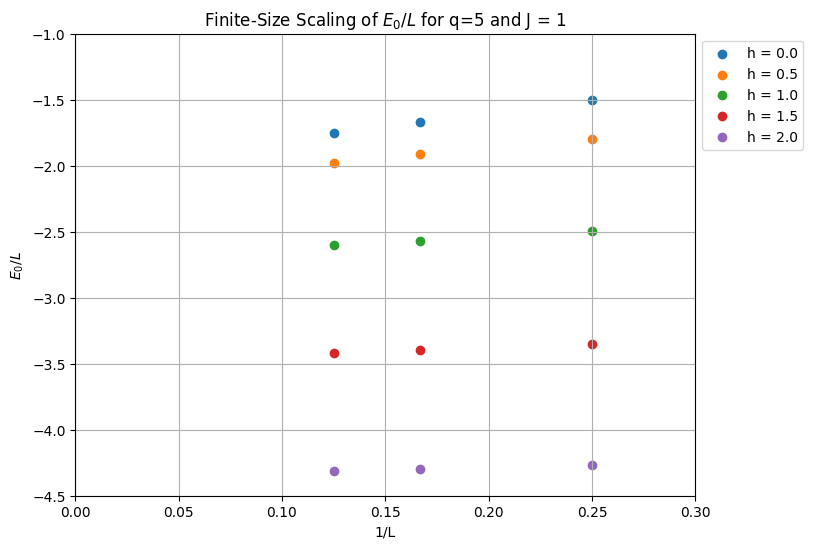

Total runtime: 137.70 seconds


In [ ]:
q = 5
J = 1
h_values = np.array([0.0, 0.5, 1.0, 1.5, 2.0])
L_values = np.array([4, 6, 8])

start_time = time.time()

inv_L = 1 / L_values  # Inverse system size (x-axis)
energies_per_L = np.zeros((len(h_values), len(L_values)))  # Store energies as 2D array

# Compute energies and store values
print("h\t1/L\tE0/L")  # Header for readability
print("="*25)
for i, h in enumerate(h_values):
    for j, L in enumerate(L_values):
        energies_per_L[i, j] = (E0_per_site(q, J, h, L))  # Compute energy per site
        print(f"{h:.2f}\t{inv_L[j]:.4f}\t{energies_per_L[i, j]:.4f}")  # Print values

for i, h in enumerate(h_values):
    for j, L in enumerate(L_values):
        energies_per_L[i, j] = (E0_per_site(q, J, h, L))  # Store properly

# Plot each h separately
plt.figure(figsize=(8, 6))
for i, h in enumerate(h_values):
    plt.scatter(inv_L, energies_per_L[i], label=f"h = {h}")

plt.xlabel("1/L")
plt.ylabel("$E_0/L$")
plt.title(f"Finite-Size Scaling of $E_0/L$ for q={q} and J = {J}")
plt.legend(loc = "upper left", bbox_to_anchor=(1, 1))
plt.grid(True)
plt.xlim(0, 0.3)
plt.ylim(-4.5, -1.0)
plt.show()

end_time = time.time()
print(f"Total runtime: {end_time - start_time:.2f} seconds")

h	1/L	E0/L
0.00	0.2500	-1.5000
0.00	0.1667	-1.6667
0.00	0.1250	-1.7500
0.50	0.2500	-1.8762
0.50	0.1667	-1.9944
0.50	0.1250	-2.0553
1.00	0.2500	-2.6151
1.00	0.1667	-2.6999
1.00	0.1250	-2.7437
1.50	0.2500	-3.4580
1.50	0.1667	-3.5189
1.50	0.1250	-3.5503
2.00	0.2500	-4.3581
2.00	0.1667	-4.4032
2.00	0.1250	-4.4260


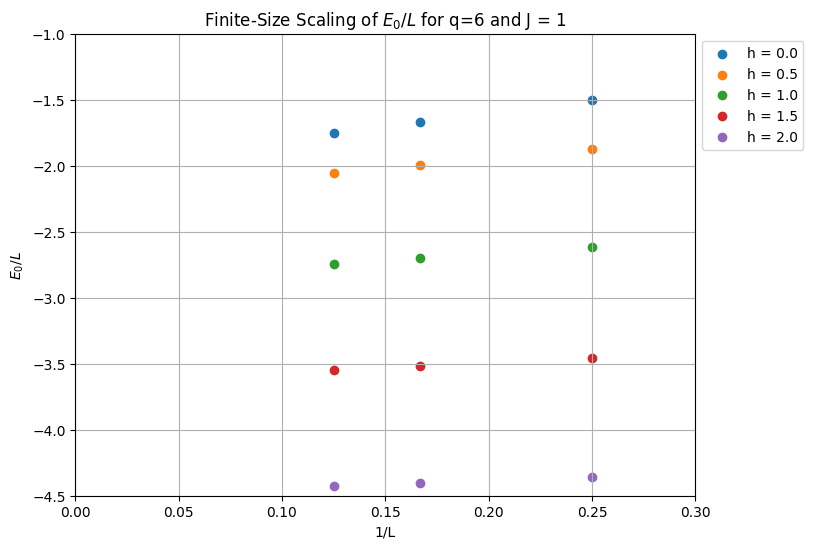

Total runtime: 660.81 seconds


In [ ]:
q = 6
J = 1
h_values = np.array([0.0, 0.5, 1.0, 1.5, 2.0])
L_values = np.array([4, 6, 8])

start_time = time.time()

inv_L = 1 / L_values  # Inverse system size (x-axis)
energies_per_L = np.zeros((len(h_values), len(L_values)))  # Store energies as 2D array

# Compute energies and store values
print("h\t1/L\tE0/L")  # Header for readability
print("="*25)
for i, h in enumerate(h_values):
    for j, L in enumerate(L_values):
        energies_per_L[i, j] = (E0_per_site(q, J, h, L))  # Compute energy per site
        print(f"{h:.2f}\t{inv_L[j]:.4f}\t{energies_per_L[i, j]:.4f}")  # Print values

for i, h in enumerate(h_values):
    for j, L in enumerate(L_values):
        energies_per_L[i, j] = (E0_per_site(q, J, h, L))  # Store properly

# Plot each h separately
plt.figure(figsize=(8, 6))
for i, h in enumerate(h_values):
    plt.scatter(inv_L, energies_per_L[i], label=f"h = {h}")

plt.xlabel("1/L")
plt.ylabel("$E_0/L$")
plt.title(f"Finite-Size Scaling of $E_0/L$ for q={q} and J = {J}")
plt.legend(loc = "upper left", bbox_to_anchor=(1, 1))
plt.grid(True)
plt.xlim(0, 0.3)
plt.ylim(-4.5, -1.0)
plt.show()

end_time = time.time()
print(f"Total runtime: {end_time - start_time:.2f} seconds")

### FINITE-SIZE SCALING OF GROUND-STATE ENERGY DENSITY (INFINITE-SYSTEM DMRG)

<ipython-input-4-9a0e86b8ad98>:30: ComplexWarning: Casting complex values to real discards the imaginary part
  transformation_matrix[:, i] = evec


h = 0.0
[-1.5        -1.66666667 -1.31448136 -0.8268247  -0.90719008 -0.96459393
 -1.00764681]
h = 0.5
[-1.79438152 -1.63469092 -1.75975914 -1.84256979 -1.89885791 -1.93920746
 -1.96949315]
h = 1.0
[-2.49784866 -2.4308648  -2.4981905  -2.54062096 -2.5694461  -2.59022712
 -2.60589239]
h = 1.5
[-3.34983474 -3.36277907 -3.39286903 -3.41115804 -3.42339443 -3.43214457
 -3.43870946]
h = 2.0
[-4.26670913 -4.24862304 -4.27694527 -4.29414761 -4.30563205 -4.31383678
 -4.31999048]


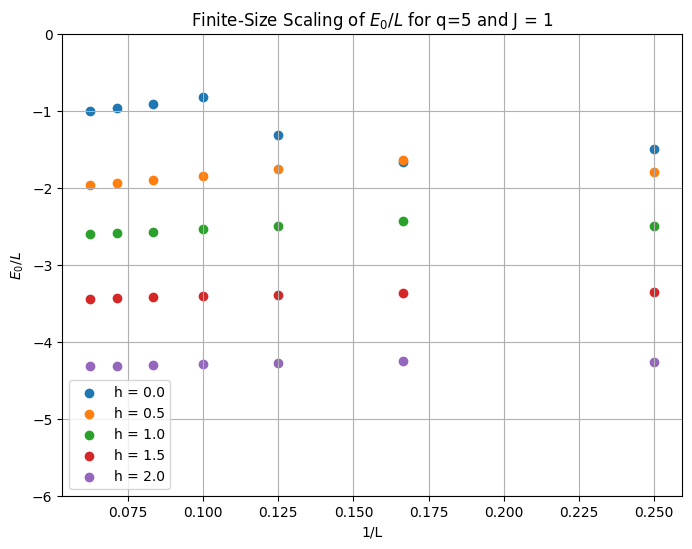

In [ ]:
# Define parameters
q = 5
J = 1
L = 16
m = 10

h_values = np.array([0.0, 0.5, 1.0, 1.5, 2.0])
L_values = np.array([4, 6, 8, 10, 12, 14, 16])
inv_L = 1 / L_values

energies_per_L = np.zeros((len(h_values), len(L_values)))  # Store energies as 2D array

for i, h in enumerate(h_values):
    energies_per_L[i] = (infinite_system_algorithm_list(q, J, h, L, m))  # Store
    print(f"h = {h}")
    print(energies_per_L[i])

# Plot each h separately
plt.figure(figsize=(8, 6))
for i, h in enumerate(h_values):
    plt.scatter(inv_L, energies_per_L[i], label=f"h = {h}")

plt.xlabel("1/L")
plt.ylabel("$E_0/L$")
plt.title(f"Finite-Size Scaling of $E_0/L$ for q={q} and J = {J}")
plt.legend()
plt.grid(True)
plt.ylim(-6, 0)
plt.show()

<ipython-input-4-9a0e86b8ad98>:30: ComplexWarning: Casting complex values to real discards the imaginary part
  transformation_matrix[:, i] = evec


h = 0.0
[-1.5        -1.66666667 -1.6259385  -1.7007508  -1.75062567 -1.78625057
 -1.81296925]
h = 0.5
[-1.87623254 -1.93212567 -2.00700677 -2.05504147 -2.08709222 -2.10999306
 -2.12717417]
h = 1.0
[-2.61512712 -2.59314128 -2.48132788 -2.55583905 -2.59751308 -2.62341132
 -2.65258729]
h = 1.5
[-3.45795899 -3.49547531 -3.37154007 -3.32480315 -3.362325   -3.37583585
 -3.40040044]
h = 2.0
[-4.35806783 -4.32629629 -4.33508114 -4.32442009 -4.31352796 -4.29830031
 -4.29537441]


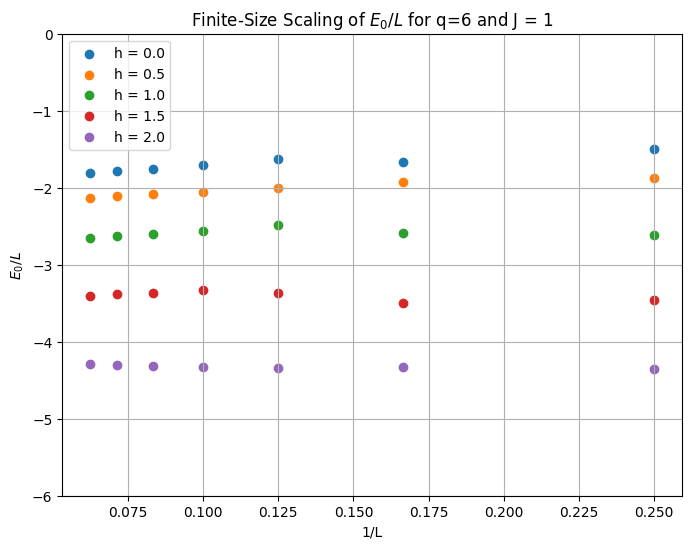

In [ ]:
# Define parameters
q = 6
J = 1
L = 16
m = 10

h_values = np.array([0.0, 0.5, 1.0, 1.5, 2.0])
L_values = np.array([4, 6, 8, 10, 12, 14, 16])
inv_L = 1 / L_values

energies_per_L = np.zeros((len(h_values), len(L_values)))  # Store energies as 2D array

for i, h in enumerate(h_values):
    energies_per_L[i] = (infinite_system_algorithm_list(q, J, h, L, m))  # Store
    print(f"h = {h}")
    print(energies_per_L[i])

# Plot each h separately
plt.figure(figsize=(8, 6))
for i, h in enumerate(h_values):
    plt.scatter(inv_L, energies_per_L[i], label=f"h = {h}")

plt.xlabel("1/L")
plt.ylabel("$E_0/L$")
plt.title(f"Finite-Size Scaling of $E_0/L$ for q={q} and J = {J}")
plt.legend()
plt.grid(True)
plt.ylim(-6, 0)
plt.show()

### FINITE-SIZE SCALING OF GROUND-STATE ENERGY DENSITY (FINITE-SYSTEM DMRG)

<ipython-input-4-9a0e86b8ad98>:30: ComplexWarning: Casting complex values to real discards the imaginary part
  transformation_matrix[:, i] = evec


h = 0.0
[np.float64(-1.6666666666666698), np.float64(-1.7500000000000053), np.float64(-1.8000000000000065), np.float64(-1.3726779962499693), np.float64(-1.8571428571428668), np.float64(-1.87500000000001)]
h = 0.5
[np.float64(-1.9086985940877137), np.float64(-1.9767383330500627), np.float64(-2.0156350493336843), np.float64(-2.0431212309425395), np.float64(-2.0627931954657246), np.float64(-2.076733591745445)]
h = 1.0
[np.float64(-2.567400543267729), np.float64(-2.6036718112818282), np.float64(-2.6259167209947423), np.float64(-2.640924562522081), np.float64(-2.651595401544828), np.float64(-2.659937985331388)]
h = 1.5
[np.float64(-3.3832226223389306), np.float64(-3.4167338642912775), np.float64(-3.430287498243721), np.float64(-3.439395349371939), np.float64(-3.4459492905458142), np.float64(-3.4508078186172626)]
h = 2.0
[np.float64(-4.298742243706866), np.float64(-4.287863980459608), np.float64(-4.322719291222), np.float64(-4.330908939305449), np.float64(-4.335506567346475), np.float64(-4.3

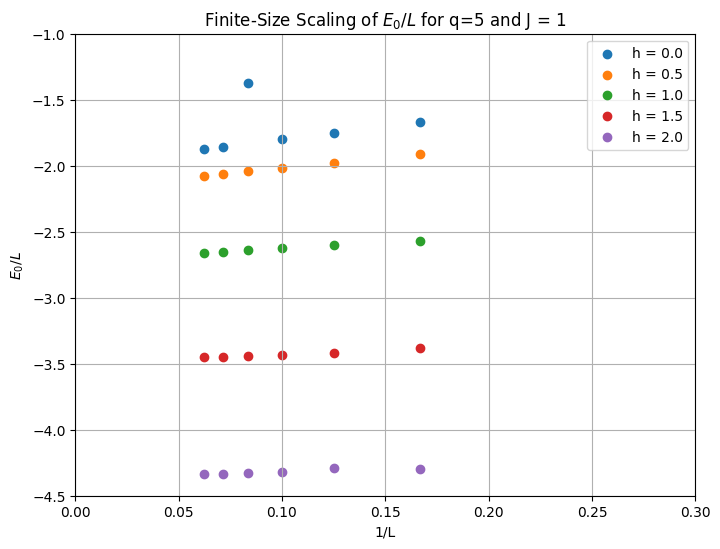

In [ ]:
q = 5
J = 1
m_warmup = 10
m_sweep_list = [10, 20, 30]
h_values = np.array([0.0, 0.5, 1.0, 1.5, 2.0])
L_values = np.array([6, 8, 10, 12, 14, 16])

inv_L = 1 / L_values
# List of lists: One inner list for each h value
energies_list = [[] for _ in h_values]

# Iterate over L and h values
for i, h in enumerate(h_values):
    for L in L_values:
        # Compute the energy values for the current (h, L) combination
        energies = finite_system_algorithm_list(q, J, h, L, m_warmup, m_sweep_list)

        # Append the energies to the corresponding list for this h
        energies_list[i].extend(energies)

plt.figure(figsize = (8, 6))
for i, h in enumerate(h_values):
    print(f"h = {h}")
    print(energies_list[i])
    plt.scatter(inv_L, energies_list[i], label=f"h = {h}", marker='o')

plt.xlim(0, 0.3)
plt.ylim(-4.5, -1.0)
plt.xlabel("1/L")
plt.ylabel("$E_0/L$")
plt.title(f"Finite-Size Scaling of $E_0/L$ for q={q} and J = {J}")
plt.grid(True)
plt.legend()
plt.show()

<ipython-input-4-9a0e86b8ad98>:30: ComplexWarning: Casting complex values to real discards the imaginary part
  transformation_matrix[:, i] = evec


h = 0.0
[np.float64(-1.6666666666666774), np.float64(-1.750000000000001), np.float64(-1.8000000000000036), np.float64(-1.833333333333335), np.float64(-1.8571428571428605), np.float64(-1.8750000000000069)]
h = 0.5
[np.float64(-1.9766500053679616), np.float64(-2.0553086730435317), np.float64(-2.092459521509584), np.float64(-2.1133690801834093), np.float64(-2.1355159376583126), np.float64(-2.1490720081007013)]
h = 1.0
[np.float64(-2.65915092068104), np.float64(-2.703041855193059), np.float64(-2.7511521235348186), np.float64(-2.7693501512436574), np.float64(-2.779173644178686), np.float64(-2.803111077065914)]
h = 1.5
[np.float64(-3.475066645579892), np.float64(-3.4932411931765484), np.float64(-3.529222951598915), np.float64(-3.521084535241894), np.float64(-3.56548662779363), np.float64(-3.577644447675068)]
h = 2.0
[np.float64(-4.373700981436876), np.float64(-4.396996519369851), np.float64(-4.391703395723659), np.float64(-4.423255351725101), np.float64(-4.410521133993739), np.float64(-4.433

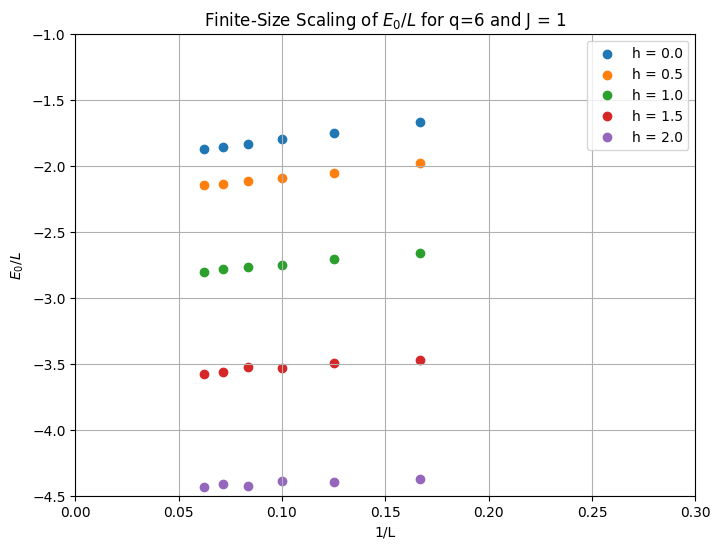

In [ ]:
q = 6
J = 1
m_warmup = 10
m_sweep_list = [10, 20, 30]
h_values = np.array([0.0, 0.5, 1.0, 1.5, 2.0])
L_values = np.array([6, 8, 10, 12, 14, 16])

inv_L = 1 / L_values
# List of lists: One inner list for each h value
energies_list = [[] for _ in h_values]

# Iterate over L and h values
for i, h in enumerate(h_values):
    for L in L_values:
        # Compute the energy values for the current (h, L) combination
        energies = finite_system_algorithm_list(q, J, h, L, m_warmup, m_sweep_list)

        # Append the energies to the corresponding list for this h
        energies_list[i].extend(energies)

plt.figure(figsize = (8, 6))
for i, h in enumerate(h_values):
    print(f"h = {h}")
    print(energies_list[i])
    plt.scatter(inv_L, energies_list[i], label=f"h = {h}", marker='o')

plt.xlim(0, 0.3)
plt.ylim(-4.5, -1.0)
plt.xlabel("1/L")
plt.ylabel("$E_0/L$")
plt.title(f"Finite-Size Scaling of $E_0/L$ for q={q} and J = {J}")
plt.grid(True)
plt.legend()
plt.show()

### FINITE-SIZE SCALING OF GROUND-STATE ENERGY DENSITY (ED & DMRG)

In [ ]:
q1 = 5
q2 = 6
m_warmup = 10
m_sweep_list = [10, 20, 30]
J = 1
h_values = np.array([0.0, 0.5, 1.0, 1.5, 2.0])
L_values1 = np.array([4, 6, 8])
L_values2 = np.array([6, 8, 10, 12, 14, 16])

start_time = time.time()

inv_L1 = 1 / L_values1
inv_L2 = 1/ L_values2
exact1 = np.zeros((len(h_values), len(L_values1)))  # Store energies as 2D array
exact2 = np.zeros((len(h_values), len(L_values1)))

# Compute energy density using exact diagonalization
for i, h in enumerate(h_values):
    for j, L in enumerate(L_values1):
        exact1[i, j] = (E0_per_site(q1, J, h, L))
        exact2[i, j] = (E0_per_site(q2, J, h, L))

# Compute energy density using finite-system DMRG
dmrg1 = [[] for _ in h_values]
dmrg2 = [[] for _ in h_values]

for i, h in enumerate(h_values):
    for L in L_values2:
        # Compute the energy values for the current (h, L) combination
        energies1 = finite_system_algorithm_list(q1, J, h, L, m_warmup, m_sweep_list)
        energies2 = finite_system_algorithm_list(q2, J, h, L, m_warmup, m_sweep_list)
        # Append the energies to the corresponding list for this h
        dmrg1[i].extend(energies1)
        dmrg2[i].extend(energies2)

<ipython-input-4-9a0e86b8ad98>:30: ComplexWarning: Casting complex values to real discards the imaginary part
  transformation_matrix[:, i] = evec


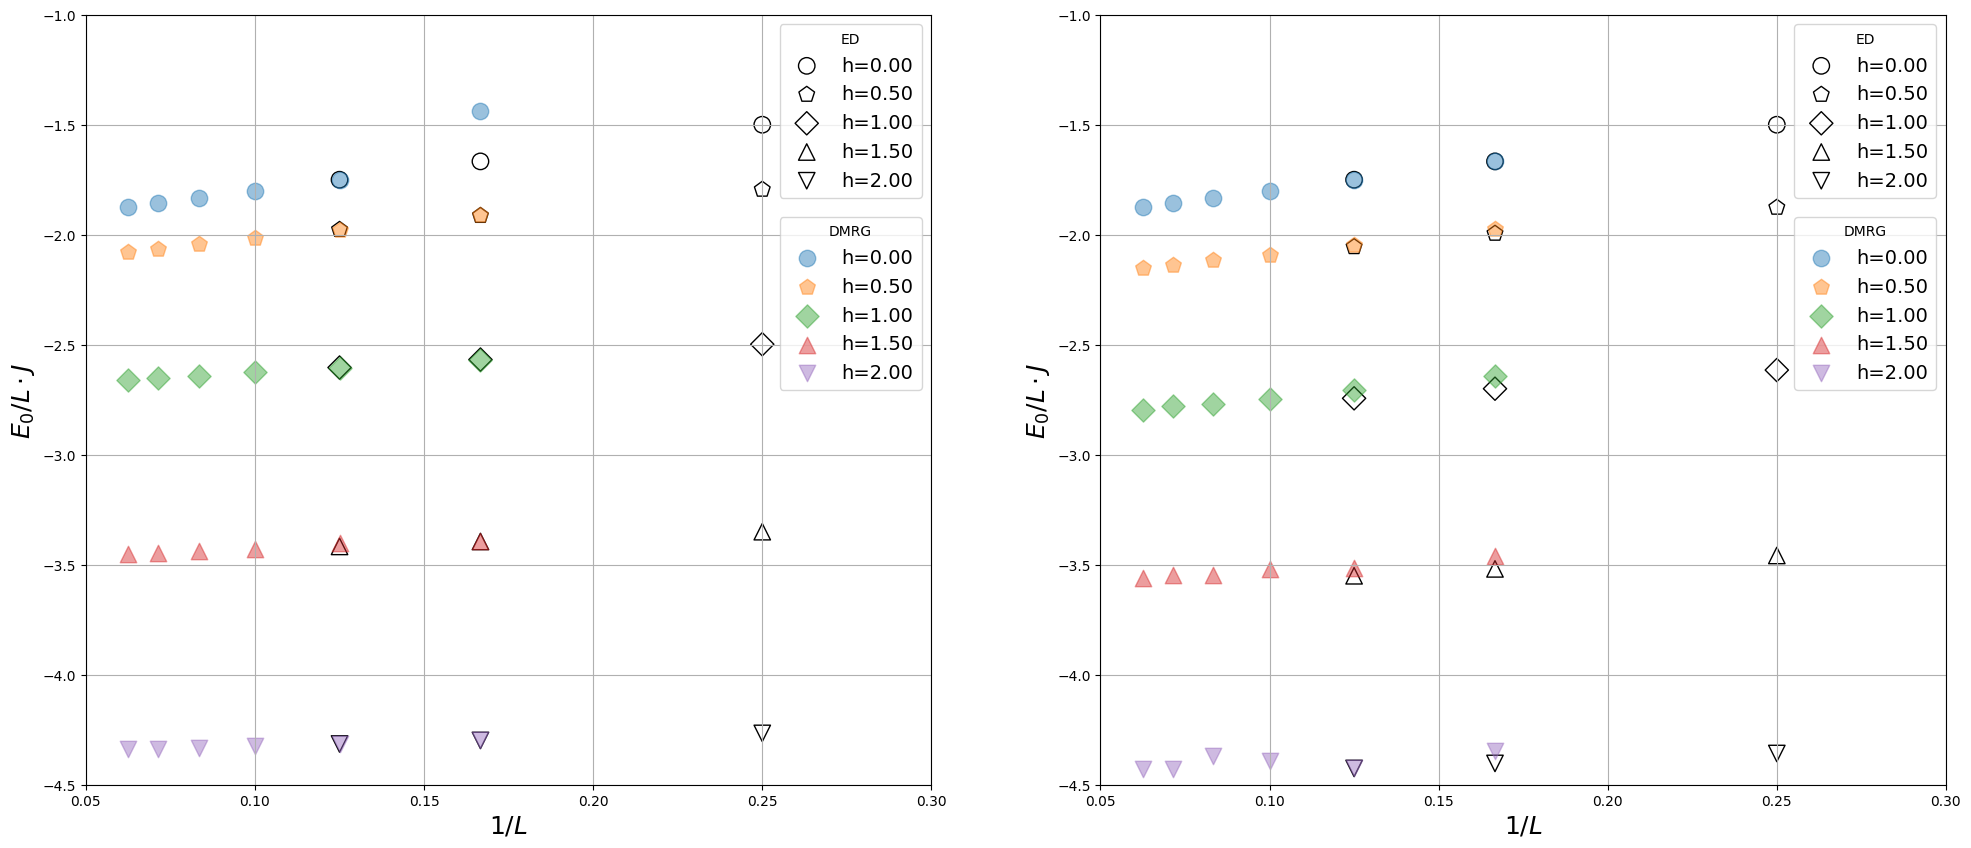

Total runtime: 4479.43 seconds


In [ ]:
inv_L1 = 1 / L_values1  # Inverse system size (x-axis)
inv_L2 = 1/ L_values2

exact_handles1 = []
exact_handles2 = []
dmrg_handles1 = []
dmrg_handles2 = []
exact_markers = ['o', 'p', 'D', '^', 'v']
dmrg_markers = ['o', 'p', 'D', '^', 'v']

fig, axs = plt.subplots(1, 2, figsize = (24, 10))
for i, h in enumerate(h_values):
    scatter1 = axs[0].scatter(inv_L1, exact1[i], marker=exact_markers[i % len(exact_markers)], s=140, label=f"h = {h}", facecolors='none', edgecolors="black")
    scatter2 = axs[0].scatter(inv_L2, dmrg1[i], marker=dmrg_markers[i % len(exact_markers)], s=140, label=f"h = {h}", alpha=0.45)

    scatter3 = axs[1].scatter(inv_L1, exact2[i], marker=exact_markers[i % len(exact_markers)], s=140, label=f"h = {h}", facecolors='none', edgecolors="black")
    scatter4 = axs[1].scatter(inv_L2, dmrg2[i], marker=dmrg_markers[i % len(exact_markers)], s=140, label=f"h = {h}", alpha=0.45)

    exact_handles1.append(scatter1)
    dmrg_handles1.append(scatter2)
    exact_handles2.append(scatter3)
    dmrg_handles2.append(scatter4)

legend1 = axs[0].legend(exact_handles1, [f"h={h:.2f}" for h in h_values], loc='upper right', bbox_to_anchor=(1.0, 1), title="ED", fontsize=14)
axs[0].add_artist(legend1)
axs[0].legend(dmrg_handles1, [f"h={h:.2f}" for h in h_values], loc='upper right', bbox_to_anchor=(1.0, 0.75), title="DMRG", fontsize=14)
axs[0].grid(True)
axs[0].set_xlim(0.05, 0.3)
axs[0].set_ylim(-4.5, -1.0)
axs[0].set_xlabel(r"$1/L$", fontsize=18)
axs[0].set_ylabel(r"$E_{0}/L \cdot J$", fontsize=18)

legend2 = axs[1].legend(exact_handles2, [f"h={h:.2f}" for h in h_values], loc='upper right', bbox_to_anchor=(1.0, 1), title="ED", fontsize=14)
axs[1].add_artist(legend2)
axs[1].legend(dmrg_handles2, [f"h={h:.2f}" for h in h_values], loc='upper right', bbox_to_anchor=(1.0, 0.75), title="DMRG", fontsize=14)
axs[1].grid(True)
axs[1].set_xlim(0.05, 0.3)
axs[1].set_ylim(-4.5, -1.0)
axs[1].set_xlabel(r"$1/L$", fontsize=18)
axs[1].set_ylabel(r"$E_{0}/L \cdot J$", fontsize=18)

plt.show()

end_time = time.time()
print(f"Total runtime: {end_time - start_time:.2f} seconds")

### EXTRAPOLATION OF GROUND-STATE ENERGY DENSITY

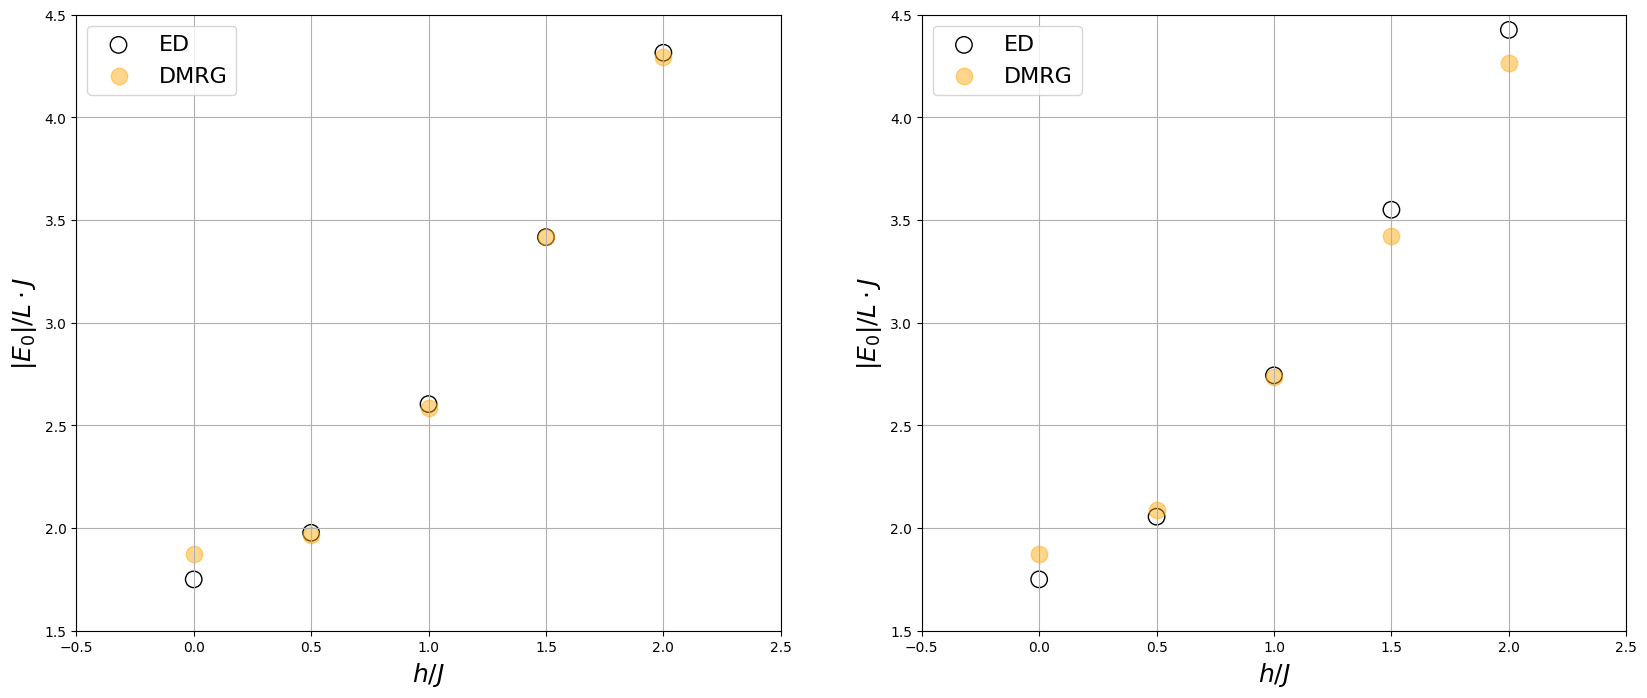

In [9]:
q1 = 5
q2 = 6
J = 1
h_values = [0.0, 0.5, 1.0, 1.5, 2.0]


exact1 = np.abs([-1.7500, -1.9769, -2.6037, -3.4169, -4.3148])
exact2 = np.abs([-1.7500, -2.0553, -2.7437, -3.5503, -4.4260])
dmrg1 = np.abs([-1.875, -1.96838552, -2.58533239, -3.41872026, -4.29503977])
dmrg2 = np.abs([-1.87354636, -2.08609958, -2.73472269, -3.42307111, -4.2662002])

fig, axs = plt.subplots(1, 2, figsize=(20, 8))

scatter1 = axs[0].scatter(h_values, exact1, marker='o', s=140, label="ED", facecolors='none', edgecolors="black")
scatter2 = axs[0].scatter(h_values, dmrg1, marker='o', s=140, label="DMRG", alpha=0.45, color='orange')
scatter3 = axs[1].scatter(h_values, exact2, marker='o', s=140, label="ED", facecolors='none', edgecolors="black")
scatter4 = axs[1].scatter(h_values, dmrg2, marker='o', s=140, label="DMRG", alpha=0.45, color="orange")

axs[0].grid(True)
axs[0].set_xlim(-0.5, 2.5)
axs[0].set_ylim(1.5, 4.5)
axs[0].set_xlabel("$h/J$", fontsize=18)
axs[0].set_ylabel("$|E_{0}|/L \cdot J$", fontsize=18)
axs[0].legend(loc="upper left", fontsize=16)

axs[1].grid(True)
axs[1].set_xlim(-0.5, 2.5)
axs[1].set_ylim(1.5, 4.5)
axs[1].set_xlabel(r"$h/J$", fontsize=18)
axs[1].set_ylabel(r"$|E_{0}|/L \cdot J$", fontsize=18)
axs[1].legend(loc="upper left", fontsize=16)

plt.show()

## ENERGY GAP PER SITE

### FINITE-SIZE SCALING OF ENERGY GAP PER SITE (EXACT DIAGONALIZATION)

h	1/L	|E1-E0|/L
0.00	0.2500	0.0000
0.00	0.1667	0.0000
0.00	0.1250	0.0000
0.50	0.2500	0.0235
0.50	0.1667	0.0068
0.50	0.1250	0.0024
1.00	0.2500	0.0992
1.00	0.1667	0.0432
1.00	0.1250	0.0238
1.50	0.2500	0.2168
1.50	0.1667	0.1127
1.50	0.1250	0.0719
2.00	0.2500	0.3601
2.00	0.1667	0.2057
2.00	0.1250	0.1413


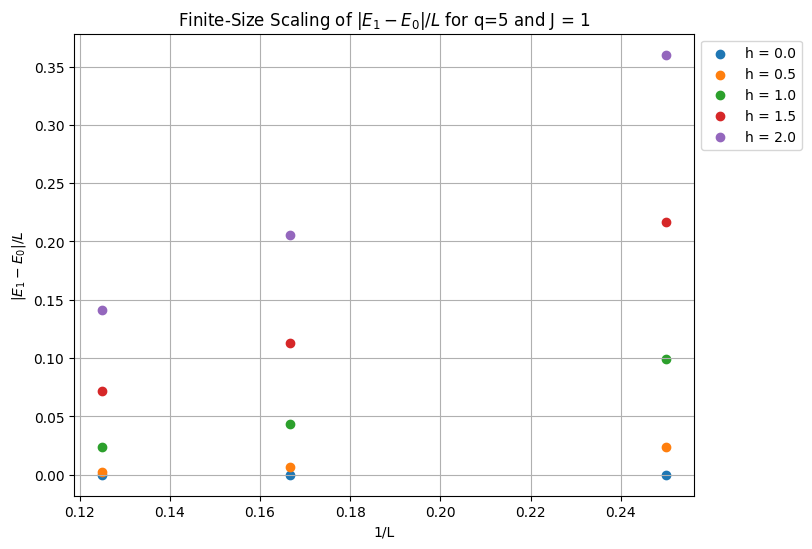

Total runtime: 220.61 seconds


In [10]:
q = 5
J = 1
h_values = np.array([0.0, 0.5, 1.0, 1.5, 2.0])
L_values = np.array([4, 6, 8])

start_time = time.time()

inv_L = 1 / L_values  # Inverse system size (x-axis)
energies_per_L = np.zeros((len(h_values), len(L_values)))  # Store energies as 2D array

# Compute energies and store values
print("h\t1/L\t|E1-E0|/L")  # Header for readability
print("="*25)
for i, h in enumerate(h_values):
    for j, L in enumerate(L_values):
        energies_per_L[i, j] = (E0_and_E1_per_site(q, J, h, L))  # Compute energy per site
        print(f"{h:.2f}\t{inv_L[j]:.4f}\t{energies_per_L[i, j]:.4f}")  # Print values

for i, h in enumerate(h_values):
    for j, L in enumerate(L_values):
        energies_per_L[i, j] = (E0_and_E1_per_site(q, J, h, L))  # Store properly

# Plot each h separately
plt.figure(figsize=(8, 6))
for i, h in enumerate(h_values):
    plt.scatter(inv_L, energies_per_L[i], label=f"h = {h}")

plt.xlabel("1/L")
plt.ylabel("$|E_{1}-E_0|/L$")
plt.title(f"Finite-Size Scaling of $|E_{1}-E_0|/L$ for q={q} and J = {J}")
plt.legend(loc = "upper left", bbox_to_anchor=(1, 1))
plt.grid(True)
plt.show()

end_time = time.time()
print(f"Total runtime: {end_time - start_time:.2f} seconds")

h	1/L	|E1-E0|/L
0.00	0.2500	0.0000
0.00	0.1667	0.0000
0.00	0.1250	0.0000
0.50	0.2500	0.0205
0.50	0.1667	0.0077
0.50	0.1250	0.0038
1.00	0.2500	0.0618
1.00	0.1667	0.0262
1.00	0.1250	0.0143
1.50	0.2500	0.1252
1.50	0.1667	0.0586
1.50	0.1250	0.0342
2.00	0.2500	0.2104
2.00	0.1667	0.1095
2.00	0.1250	0.0699


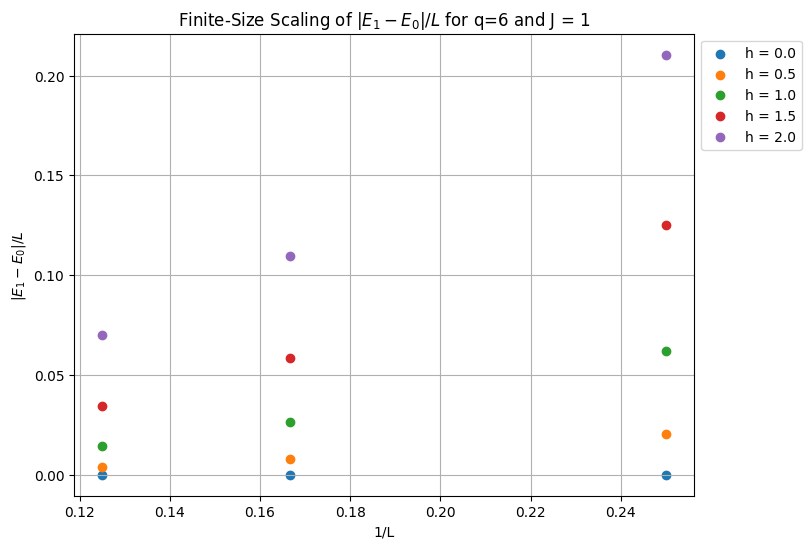

Total runtime: 960.27 seconds


In [11]:
q = 6
J = 1
h_values = np.array([0.0, 0.5, 1.0, 1.5, 2.0])
L_values = np.array([4, 6, 8])

start_time = time.time()

inv_L = 1 / L_values  # Inverse system size (x-axis)
energies_per_L = np.zeros((len(h_values), len(L_values)))  # Store energies as 2D array

# Compute energies and store values
print("h\t1/L\t|E1-E0|/L")  # Header for readability
print("="*25)
for i, h in enumerate(h_values):
    for j, L in enumerate(L_values):
        energies_per_L[i, j] = (E0_and_E1_per_site(q, J, h, L))  # Compute energy per site
        print(f"{h:.2f}\t{inv_L[j]:.4f}\t{energies_per_L[i, j]:.4f}")  # Print values

for i, h in enumerate(h_values):
    for j, L in enumerate(L_values):
        energies_per_L[i, j] = (E0_and_E1_per_site(q, J, h, L))  # Store properly

# Plot each h separately
plt.figure(figsize=(8, 6))
for i, h in enumerate(h_values):
    plt.scatter(inv_L, energies_per_L[i], label=f"h = {h}")

plt.xlabel("1/L")
plt.ylabel("$|E_{1}-E_0|/L$")
plt.title(f"Finite-Size Scaling of $|E_{1}-E_0|/L$ for q={q} and J = {J}")
plt.legend(loc = "upper left", bbox_to_anchor=(1, 1))
plt.grid(True)
plt.show()

end_time = time.time()
print(f"Total runtime: {end_time - start_time:.2f} seconds")

### FINITE-SIZE SCALING OF ENERGY GAP PER SITE (FINITE-SYSTEM DMRG)

<ipython-input-8-296efb8f8d6d>:45: ComplexWarning: Casting complex values to real discards the imaginary part
  transformation_matrix[:, i] = evec


h = 0.0
[np.float64(0.19621449744125533), np.float64(0.1963631350709294), np.float64(0.2763932022500235), np.float64(0.23032766854169098)]
h = 0.5
[np.float64(0.006834099311052277), np.float64(0.002518436021416548), np.float64(0.0026002078349893765), np.float64(0.0003625158148349665)]
h = 1.0
[np.float64(0.0456962236615143), np.float64(0.02377849308915181), np.float64(0.01492057862340097), np.float64(0.010127101347541098)]
h = 1.5
[np.float64(0.10698694327519871), np.float64(0.07192557057034321), np.float64(0.051375484798169425), np.float64(0.03925920539004224)]
h = 2.0
[np.float64(0.23960978375005895), np.float64(0.1531524017391952), np.float64(0.1069722129749465), np.float64(0.08598017728857894)]


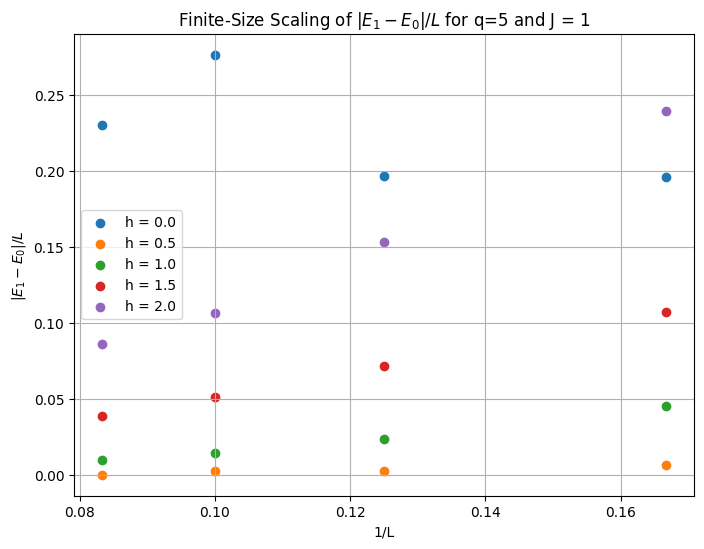

In [12]:
q = 5
J = 1
m_warmup = 10
m_sweep_list = [10, 20, 30]
h_values = np.array([0.0, 0.5, 1.0, 1.5, 2.0])
L_values = np.array([6, 8, 10, 12])

inv_L = 1 / L_values
# List of lists: One inner list for each h value
energy_gap_list = [[] for _ in h_values]

# Iterate over L and h values
for i, h in enumerate(h_values):
    for L in L_values:
        # Compute the energy values for the current (h, L) combination
        e_gap = finite_system_algorithm_gap(q, J, h, L, m_warmup, m_sweep_list)

        # Append the energies to the corresponding list for this h
        energy_gap_list[i].extend(e_gap)

plt.figure(figsize = (8, 6))
for i, h in enumerate(h_values):
    print(f"h = {h}")
    print(energy_gap_list[i])
    plt.scatter(inv_L, energy_gap_list[i], label=f"h = {h}", marker='o')

plt.xlabel("1/L")
plt.ylabel("$|E_1-E_0|/L$")
plt.title(f"Finite-Size Scaling of $|E_1-E_0|/L$ for q={q} and J = {J}")
plt.grid(True)
plt.legend()
plt.show()

<ipython-input-8-296efb8f8d6d>:45: ComplexWarning: Casting complex values to real discards the imaginary part
  transformation_matrix[:, i] = evec


h = 0.0
[np.float64(0.1974387387001076), np.float64(0.25000000000000355), np.float64(0.19999999999999646), np.float64(0.16666666666667376)]
h = 0.5
[np.float64(0.001372981995581668), np.float64(3.3609461035144506e-05), np.float64(5.636215348694407e-05), np.float64(0.0012735795945338542)]
h = 1.0
[np.float64(0.013606590468951593), np.float64(0.0003364297548236195), np.float64(0.00038613259380611), np.float64(6.476248315460491e-05)]
h = 1.5
[np.float64(0.02506262054370545), np.float64(0.011120722923854132), np.float64(0.009161139254883465), np.float64(0.0004519144368296442)]
h = 2.0
[np.float64(0.0785633305173133), np.float64(0.059784766373446985), np.float64(0.041144043254178794), np.float64(0.014343583188946832)]


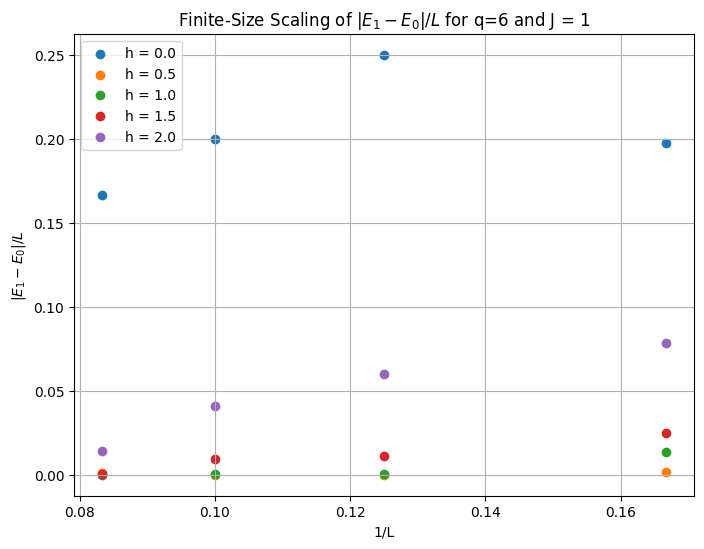

In [13]:
q = 6
J = 1
m_warmup = 10
m_sweep_list = [10, 20, 30]
h_values = np.array([0.0, 0.5, 1.0, 1.5, 2.0])
L_values = np.array([6, 8, 10, 12])

inv_L = 1 / L_values
# List of lists: One inner list for each h value
energy_gap_list = [[] for _ in h_values]

# Iterate over L and h values
for i, h in enumerate(h_values):
    for L in L_values:
        # Compute the energy values for the current (h, L) combination
        e_gap = finite_system_algorithm_gap(q, J, h, L, m_warmup, m_sweep_list)

        # Append the energies to the corresponding list for this h
        energy_gap_list[i].extend(e_gap)

plt.figure(figsize = (8, 6))
for i, h in enumerate(h_values):
    print(f"h = {h}")
    print(energy_gap_list[i])
    plt.scatter(inv_L, energy_gap_list[i], label=f"h = {h}", marker='o')

plt.xlabel("1/L")
plt.ylabel("$|E_1-E_0|/L$")
plt.title(f"Finite-Size Scaling of $|E_1-E_0|/L$ for q={q} and J = {J}")
plt.grid(True)
plt.legend()
plt.show()

### FINITE-SIZE SCALING OF ENERGY GAP PER SITE (ED & DMRG)

In [14]:
q1 = 5
m_warmup = 10
m_sweep_list = [10, 20, 30]
J = 1
h_values = np.array([0.5, 1.0, 1.5])
L_values1 = np.array([4, 6, 8])
L_values2 = np.array([6, 8, 10, 12])

start_time = time.time()

inv_L1 = 1 / L_values1
inv_L2 = 1/ L_values2
exact1 = np.zeros((len(h_values), len(L_values1)))  # Store energies as 2D array
exact2 = np.zeros((len(h_values), len(L_values1)))

# Compute energy density using finite-system DMRG
dmrg1 = [[] for _ in h_values]

# Compute energy density using exact diagonalization
for i, h in enumerate(h_values):
    for j, L in enumerate(L_values1):
        exact1[i, j] = (E0_and_E1_per_site(q1, J, h, L))

for i, h in enumerate(h_values):
    for L in L_values2:
        # Compute the energy values for the current (h, L) combination
        energies1 = finite_system_algorithm_gap(q1, J, h, L, m_warmup, m_sweep_list)
        # Append the energies to the corresponding list for this h
        dmrg1[i].extend(energies1)

end_time = time.time()
print(f"Total runtime: {end_time - start_time:.2f} seconds")

<ipython-input-8-296efb8f8d6d>:45: ComplexWarning: Casting complex values to real discards the imaginary part
  transformation_matrix[:, i] = evec


Total runtime: 1204.43 seconds


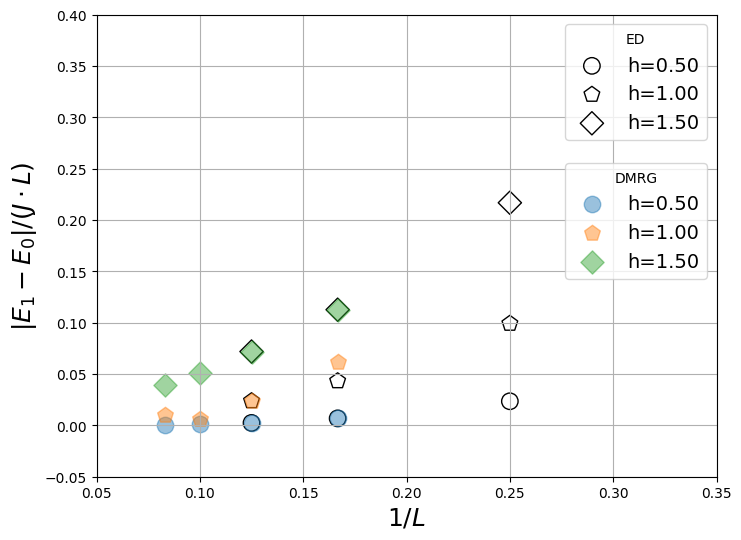

Total runtime: 1936.93 seconds


In [19]:
plt.style.use('default')

inv_L1 = 1 / L_values1  # Inverse system size (x-axis)
inv_L2 = 1/ L_values2

exact_handles1 = []
exact_handles2 = []
dmrg_handles1 = []
dmrg_handles2 = []
exact_markers = ['o', 'p', 'D', '^', 'v']
dmrg_markers = ['o', 'p', 'D', '^', 'v']

fig, ax = plt.subplots(figsize=(8,6))
for i, h in enumerate(h_values):
    scatter1 = ax.scatter(inv_L1, exact1[i], marker=exact_markers[i % len(exact_markers)], s=140, label=f"h = {h}", facecolors='none', edgecolors="black")
    scatter2 = ax.scatter(inv_L2, dmrg1[i], marker=dmrg_markers[i % len(exact_markers)], s=140, label=f"h = {h}", alpha=0.45)

    exact_handles1.append(scatter1)
    dmrg_handles1.append(scatter2)

legend1 = ax.legend(exact_handles1, [f"h={h:.2f}" for h in h_values], loc='upper right', bbox_to_anchor=(1.0, 1.0), title="ED", fontsize=14)
ax.legend(dmrg_handles1, [f"h={h:.2f}" for h in h_values], loc='upper right', bbox_to_anchor=(1.0, 0.7), title="DMRG", fontsize=14)
ax.add_artist(legend1)
ax.grid(True)
ax.set_xlim(0.05, 0.35)
ax.set_ylim(-0.05, 0.4)
ax.set_xlabel(r"$1/L$", fontsize=18)
ax.set_ylabel(r"$|E_{1}-E_{0}|/(J \cdot L)$", fontsize=18)

plt.show()

end_time = time.time()
print(f"Total runtime: {end_time - start_time:.2f} seconds")

## ENTANGLEMENT SPECTRUM

<ipython-input-3-e34bf0555ded>:94: ComplexWarning: Casting complex values to real discards the imaginary part
  transformation_matrix[:, i] = evec


truncation error: 7.337952467878495e-11
truncation error: 7.147482605773803e-11
truncation error: 5.747282205703641e-09
truncation error: 6.001643193531692e-08
truncation error: 2.686655191652676e-07
truncation error: 6.771065911292951e-07


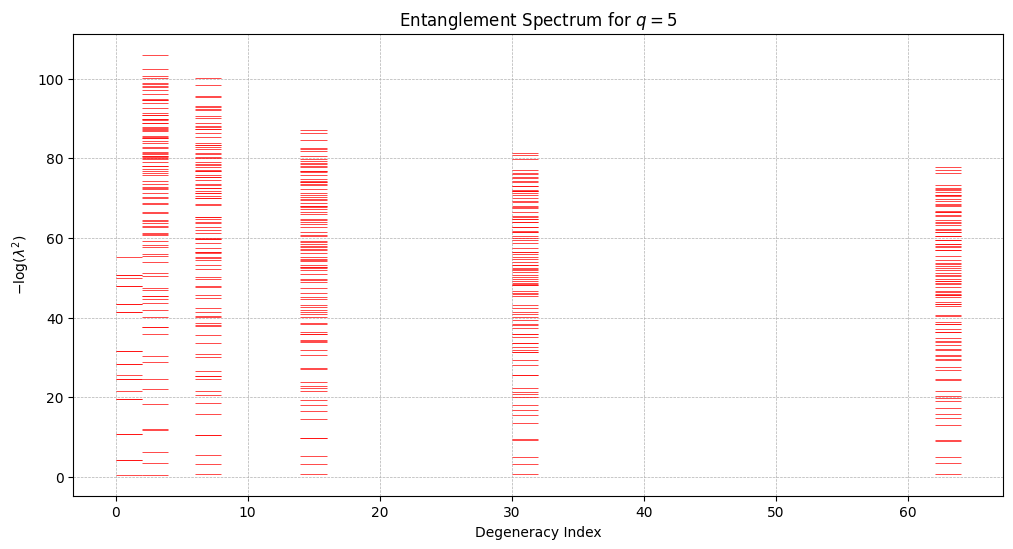

In [20]:
q=5
L=14
h=1.0
J=1.0
m=20

eigenvalues = entanglement(q, J, h, L, m)

eigenvalues = [np.asarray(evals) for evals in eigenvalues]
# Apply the log transformation
entanglement_spec = [-np.log(evals**2) for evals in eigenvalues]

# Flatten the eigenvalues into a single array for degeneracy counting
flat_eigenvalues = np.concatenate(eigenvalues)

# Count the degeneracy
degeneracy = Counter(flat_eigenvalues)

# Generate the x-coordinates considering explicit degeneracy
x_positions = []
for step_eigenvalues in eigenvalues:
    for ev in step_eigenvalues:
        x_positions.extend(range(1, degeneracy[ev] + 1))  # Append x-values for each occurrence

# Plotting
plt.figure(figsize=(12, 6))

x_offset = 0  # Offset for separating steps
step_width = 1  # Space between steps

for idx, spec in enumerate(entanglement_spec):
    x_values = []

    # For each eigenvalue in the current step
    for ev in eigenvalues[idx]:
        # Generate x-values for the degeneracy occurrences
        x_values.extend(range(1, degeneracy[ev] + 1))

    # Add offset to separate steps
    x_values = np.array(x_values) + x_offset

    # Plot the entanglement spectrum with hlines
    plt.hlines(spec, x_values - 1, x_values + 1, colors='red', linewidth=0.5)

    # Add spacing between DMRG steps
    x_offset += max(x_values) + step_width

# Labels and title
plt.xlabel("Degeneracy Index")
plt.ylabel(r"$-\log(\lambda^2)$")
plt.title(f"Entanglement Spectrum for $q={q}$")
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

<ipython-input-3-e34bf0555ded>:94: ComplexWarning: Casting complex values to real discards the imaginary part
  transformation_matrix[:, i] = evec


truncation error: 1.4539047743511446e-09
truncation error: 3.826072791923707e-11
truncation error: 1.7366156956910572e-08
truncation error: 1.9229245695751018e-07
truncation error: 7.425211864253711e-07
truncation error: 4.372381591233321e-07


<ipython-input-21-4ec760755bfa>:11: RuntimeWarning: invalid value encountered in log
  entanglement_spec = [-np.log(evals) for evals in eigenvalues]


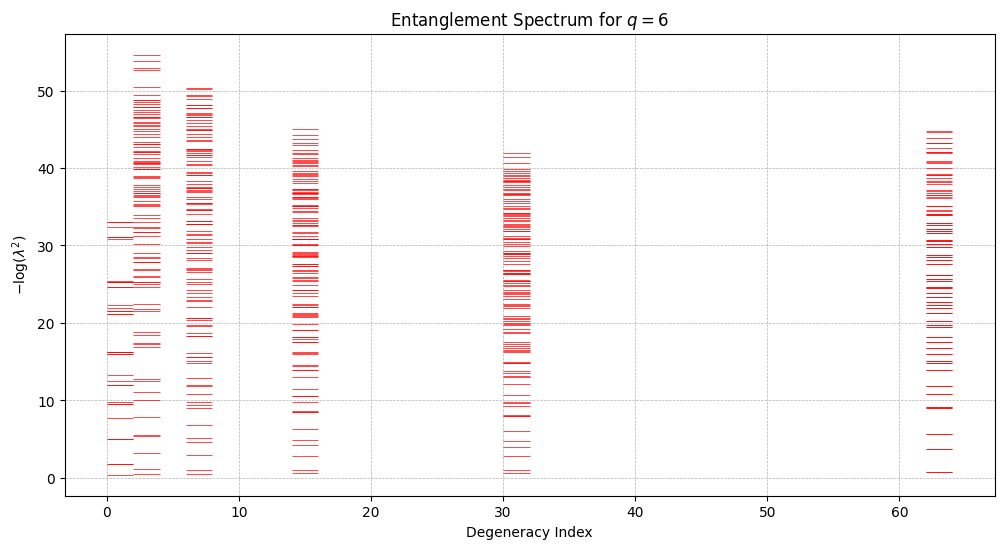

In [21]:
q=6
L=14
h=1.0
J=1.0
m=20

eigenvalues = entanglement(q, J, h, L, m)

eigenvalues = [np.asarray(evals) for evals in eigenvalues]
# Apply the log transformation
entanglement_spec = [-np.log(evals) for evals in eigenvalues]

# Flatten the eigenvalues into a single array for degeneracy counting
flat_eigenvalues = np.concatenate(eigenvalues)

# Count the degeneracy
degeneracy = Counter(flat_eigenvalues)

# Generate the x-coordinates considering explicit degeneracy
x_positions = []
for step_eigenvalues in eigenvalues:
    for ev in step_eigenvalues:
        x_positions.extend(range(1, degeneracy[ev] + 1))  # Append x-values for each occurrence

# Plotting
plt.figure(figsize=(12, 6))

x_offset = 0  # Offset for separating steps
step_width = 1  # Space between steps

for idx, spec in enumerate(entanglement_spec):
    x_values = []

    # For each eigenvalue in the current step
    for ev in eigenvalues[idx]:
        # Generate x-values for the degeneracy occurrences
        x_values.extend(range(1, degeneracy[ev] + 1))

    # Add offset to separate steps
    x_values = np.array(x_values) + x_offset

    # Plot the entanglement spectrum with hlines
    plt.hlines(spec, x_values - 1, x_values + 1, colors='red', linewidth=0.5)

    # Add spacing between DMRG steps
    x_offset += max(x_values) + step_width

# Labels and title
plt.xlabel("Degeneracy Index")
plt.ylabel(r"$-\log(\lambda^2)$")
plt.title(f"Entanglement Spectrum for $q={q}$")
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

<ipython-input-3-e34bf0555ded>:94: ComplexWarning: Casting complex values to real discards the imaginary part
  transformation_matrix[:, i] = evec


truncation error: 4.396596493871918e-06
truncation error: 1.8865619400010303e-08
truncation error: 3.913318787462927e-06
truncation error: 1.0383669952651609e-05
truncation error: 1.4979474205367715e-05
truncation error: 1.648953880117876e-05
truncation error: 1.5602105488454754e-05
truncation error: 1.4200943265207933e-05
truncation error: 1.3491936389331549e-05


<ipython-input-22-6145664782a0>:13: RuntimeWarning: invalid value encountered in log
  entanglement_spec = [-np.log(evals) for evals in eigenvalues]


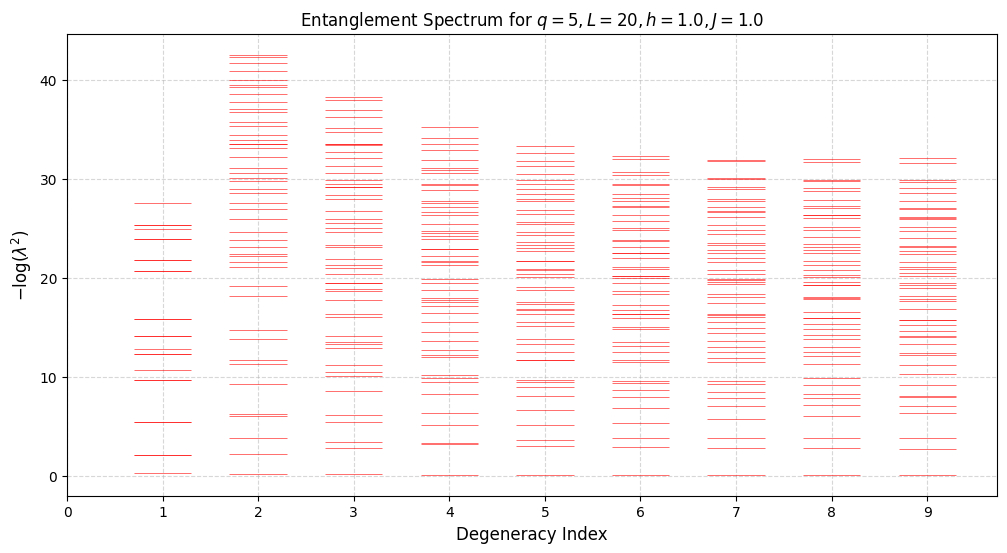

In [22]:
# --- Parameters ---
q = 5
L = 20
h = 1.0
J = 1.0
m = 10

# --- Compute Entanglement Spectrum ---
eigenvalues = entanglement(q, J, h, L, m)
eigenvalues = [np.asarray(evals) for evals in eigenvalues]

# --- Apply log transformation ---
entanglement_spec = [-np.log(evals) for evals in eigenvalues]

# --- Flatten eigenvalues and count degeneracy ---
flat_eigenvalues = np.concatenate(eigenvalues)
degeneracy = Counter(flat_eigenvalues)

# --- Prepare x-coordinates and y-values ---
x_positions = []
y_values = []

# Map eigenvalues to x-positions with degeneracy occurrences
x_offset = 0  # To separate different DMRG steps
#step_width = 2  # Space between steps

for step_idx, spec in enumerate(entanglement_spec):
    for ev, y in zip(eigenvalues[step_idx], spec):
        for d in range(1, degeneracy[ev] + 1):
            x_positions.append(d + x_offset)
            y_values.append(y)

    # Add spacing between steps
    x_offset += max(degeneracy.values()) #+ step_width

# --- Plotting ---
plt.figure(figsize=(12, 6))

# Plot hlines for each eigenvalue occurrence
line_width = 0.4
for x, y in zip(x_positions, y_values):
    plt.hlines(y, x - 0.3, x + 0.3, colors='red', linewidth=line_width)

# Labels and title
plt.xlabel("Degeneracy Index", fontsize=12)
plt.ylabel(r"$-\log(\lambda^2)$", fontsize=12)
plt.title(f"Entanglement Spectrum for $q={q}, L={L}, h={h}, J={J}$")
x_tick_positions = np.arange(0, max(x_positions) + 1, 1)  # Tick every 5 units
plt.xticks(x_tick_positions)
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

<ipython-input-3-e34bf0555ded>:94: ComplexWarning: Casting complex values to real discards the imaginary part
  transformation_matrix[:, i] = evec


truncation error: 1.173389616349052e-05
truncation error: 1.5989534885019197e-07
truncation error: 2.9408889412607664e-07
truncation error: 4.67092284739401e-07
truncation error: 1.4925503470708534e-05
truncation error: 1.6024355051769135e-06
truncation error: 3.754541494926933e-06
truncation error: 2.2546859522742935e-05
truncation error: 5.048489647663246e-05


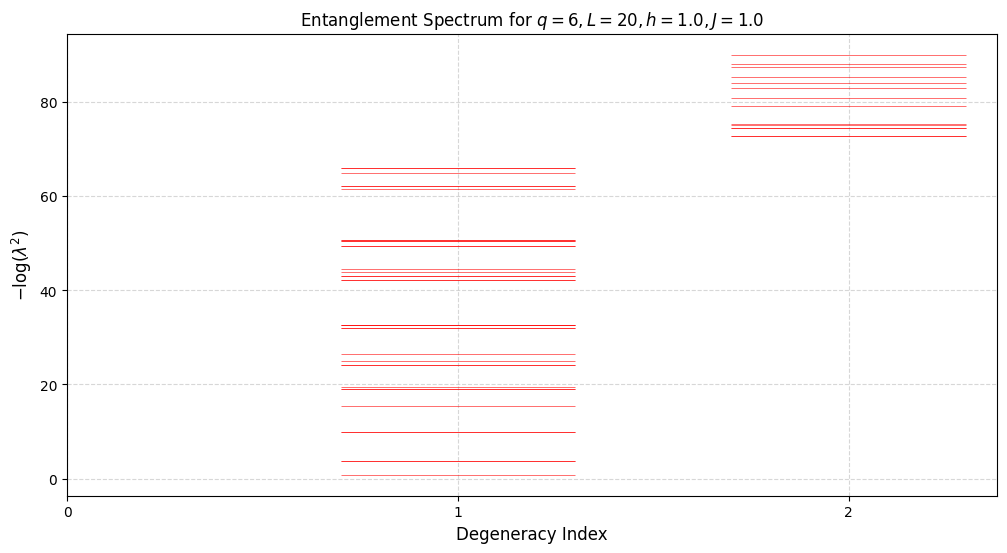

In [23]:
# --- Parameters ---
q = 6
L = 20
h = 1.0
J = 1.0
m = 10

# --- Compute Entanglement Spectrum ---
eigenvalues = entanglement(q, J, h, L, m)
eigenvalues = [np.asarray(evals) for evals in eigenvalues]

# --- Apply log transformation ---
entanglement_spec = [-np.log(evals**2) for evals in eigenvalues]

# --- Flatten eigenvalues and count degeneracy ---
flat_eigenvalues = np.concatenate(eigenvalues)[:50]
degeneracy = Counter(flat_eigenvalues)

# --- Prepare x-coordinates and y-values ---
x_positions = []
y_values = []

# Map eigenvalues to x-positions with degeneracy occurrences
x_offset = 0  # To separate different DMRG steps
#step_width = 2  # Space between steps

for step_idx, spec in enumerate(entanglement_spec):
    for ev, y in zip(eigenvalues[step_idx], spec):
        for d in range(1, degeneracy[ev] + 1):
            x_positions.append(d + x_offset)
            y_values.append(y)

    # Add spacing between steps
    x_offset += max(degeneracy.values()) #+ step_width

# --- Plotting ---
plt.figure(figsize=(12, 6))

# Plot hlines for each eigenvalue occurrence
line_width = 0.4
for x, y in zip(x_positions, y_values):
    plt.hlines(y, x - 0.3, x + 0.3, colors='red', linewidth=line_width)

# Labels and title
plt.xlabel("Degeneracy Index", fontsize=12)
plt.ylabel(r"$-\log(\lambda^2)$", fontsize=12)
plt.title(f"Entanglement Spectrum for $q={q}, L={L}, h={h}, J={J}$")
plt.grid(True, linestyle='--', alpha=0.5)
x_tick_positions = np.arange(0, max(x_positions) + 1, 1)  # Tick every 5 units
plt.xticks(x_tick_positions)
plt.show()